<a href="https://colab.research.google.com/github/RutgerEttes/PubMedBERT-Question-Classification/blob/main/question_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run the code below we need to collect the data from the github page. To download the pretrained model weights, we need to install git lfs also.

In [ ]:
!sudo apt install git-lfs
!git lfs install
!git clone https://github.com/RutgerEttes/PubMedBERT-Question-Classification.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,882 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 160975 files and directories c

Next we need to install and import the necessary libraries.

In [ ]:
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 torchtext==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers==4.3.0
!pip install deepspeed
!pip install mpi4py

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.3MB/s eta 0:04:19tcmalloc: large alloc 1147494400 bytes == 0x55df5d762000 @  0x7f4ed32ed615 0x55df24af306c 0x55df24bd2eba 0x55df24af5e8d 0x55df24be799d 0x55df24b69fe9 0x55df24b64b0e 0x55df24af777a 0x55df24b69e50 0x55df24b64b0e 0x55df24af777a 0x55df24b6686a 0x55df24be87c6 0x55df24b65ee2 0x55df24be87c6 0x55df24b65ee2 0x55df24be87c6 0x55df24b65ee2 0x55df24be87c6 0x55df24c6a431 0x55df24bcb049 0x55df24b35c84 0x55df24af68e9 0x55df24b6aade 0x55df24af769a 0x55df24b65a45 0x55df24b64e0d 0x55df24af777a 0x55df24b65a45 0x55df24af769a 0x55df24b65a45
     |█████████████████████████████▏  | 1055.7MB 1.3MB/s eta 0:01:21tcmalloc: large alloc 1434370048 bytes == 0x55dfa1db8000 @  0x7f4ed32ed615 0x55df24af306c 0x55df24bd2eba 0x55df24af5e8d 0x55df24be799d 0x55df24b69fe9 0x55df24b64b0e 0x55df24af777a 0x55df24b69e50 0x55df24b64b0e 0x55df24af777a 0x55df24b6686a 0x55df24be87c6 0x55df24b65ee2 0

In [ ]:
import transformers
import pandas as pd
import numpy as np
import sklearn
import csv
import matplotlib.pyplot as plt
from collections import Counter
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from deepspeed.utils import logger
logger.setLevel(50)

utils.py contains a number of functions for preprocessing the data and creating some graphs.

In [ ]:
!cp /content/PubMedBERT-Question-Classification/utils.py .
import utils

In principle all datasets have been prepared to for use in the prepare_datasets function, but should you want to create *dataCOVID-Dialogue-Dataset-English_questions.tsv* and *dataicliniq_dialogue_questions.tsv* from scratch, simply run the following function with the desired input and output filepaths:


```
preprocess_to_tsv(data_path, save_to)
```



In [ ]:
ichi_train_path = '/content/PubMedBERT-Question-Classification/data/ICHI2016-TrainData.tsv'
ichi_test_path = '/content/PubMedBERT-Question-Classification/data/new_ICHI2016-TestData_label.tsv'
icliniq_annotated_path = '/content/PubMedBERT-Question-Classification/data/icliniq_annotated.tsv'
COVID_annotated_path = '/content/PubMedBERT-Question-Classification/data/COVID_annotated.tsv'
icliniq_path = '/content/PubMedBERT-Question-Classification/data/dataicliniq_dialogue_questions.tsv'
COVID_path = '/content/PubMedBERT-Question-Classification/data/dataCOVID-Dialogue-Dataset-English_questions.tsv'

In [ ]:
filepaths = [ichi_train_path,
ichi_test_path,
COVID_annotated_path,
icliniq_annotated_path,
COVID_path,
icliniq_path]

train_dataset, val_dataset, test_dataset, COVID_annotated_dataset, icliniq_annotated_dataset, COVID_dataset, icliniq_dataset = utils.prepare_datasets(filepaths)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    local_rank=0,
    deepspeed='/content/PubMedBERT-Question-Classification/ds_config.json',
    load_best_model_at_end=True,
    evaluation_strategy='steps',
    eval_steps=100,
    metric_for_best_model= 'accuracy',
    logging_steps = 100,
    save_total_limit=2
)

You can either use the pretrained model weights stored in the github repository by running the code cell below, or newly finetune PubMedBERT model weights by running the cell under it.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('/content/PubMedBERT-Question-Classification/model', num_labels=7).to('cuda')

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=utils.compute_metrics
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", num_labels=7)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=utils.compute_metrics
)

trainer.train()

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Ber

Using /root/.cache/torch_extensions as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/fused_adam/build.ninja...
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module fused_adam...
Time to load fused_adam op: 22.813881874084473 seconds
Checking ZeRO support for optimizer=FusedAdam type=<class 'deepspeed.ops.adam.fused_adam.FusedAdam'>
Using /root/.cache/torch_extensions as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/utils...
Emitting ninja build file /root/.cache/torch_extensions/utils/build.ninja...
Building extension module utils...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module utils..

Step,Training Loss,Validation Loss,Accuracy,Demo f1,Demo precision,Demo recall,Dise f1,Dise precision,Dise recall,Faml f1,Faml precision,Faml recall,Goal f1,Goal precision,Goal recall,Preg f1,Preg precision,Preg recall,Socl f1,Socl precision,Socl recall,Trmt f1,Trmt precision,Trmt recall,Runtime,Samples Per Second
100,1.650900,1.175781,0.586875,0.305419,0.352273,0.269565,0.590510,0.513761,0.694215,0.837022,0.776119,0.908297,0.746411,0.852459,0.663830,0.635514,0.496350,0.883117,0.302583,0.953488,0.179825,0.503778,0.520833,0.487805,17.851900,89.626000
200,1.127200,1.017578,0.638750,0.273684,0.709091,0.169565,0.600000,0.487113,0.780992,0.837209,0.752613,0.943231,0.787440,0.910615,0.693617,0.667870,0.572755,0.800866,0.586433,0.585153,0.587719,0.558140,0.690647,0.468293,18.080500,88.493000
300,1.068300,0.978027,0.656250,0.486216,0.573964,0.421739,0.632444,0.628571,0.636364,0.874735,0.851240,0.899563,0.707547,0.561097,0.957447,0.684015,0.599349,0.796537,0.588889,0.803030,0.464912,0.504854,0.750000,0.380488,18.297100,87.446000
400,0.924300,0.828613,0.720625,0.584821,0.600917,0.569565,0.680328,0.674797,0.685950,0.881356,0.855967,0.908297,0.838207,0.773381,0.914894,0.712788,0.691057,0.735931,0.654912,0.769231,0.570175,0.656790,0.665000,0.648780,18.344700,87.219000
500,0.711300,0.829102,0.716250,0.576497,0.588235,0.565217,0.681725,0.677551,0.685950,0.878981,0.855372,0.903930,0.835937,0.772563,0.910638,0.702929,0.680162,0.727273,0.649616,0.779141,0.557018,0.653659,0.653659,0.653659,18.346900,87.208000
600,0.718700,0.829102,0.716250,0.576497,0.588235,0.565217,0.681725,0.677551,0.685950,0.878981,0.855372,0.903930,0.835937,0.772563,0.910638,0.702929,0.680162,0.727273,0.649616,0.779141,0.557018,0.653659,0.653659,0.653659,18.355500,87.167000
700,0.745700,0.829102,0.716250,0.576497,0.588235,0.565217,0.681725,0.677551,0.685950,0.878981,0.855372,0.903930,0.835937,0.772563,0.910638,0.702929,0.680162,0.727273,0.649616,0.779141,0.557018,0.653659,0.653659,0.653659,18.341200,87.235000
800,0.747300,0.829102,0.716250,0.576497,0.588235,0.565217,0.681725,0.677551,0.685950,0.878981,0.855372,0.903930,0.835937,0.772563,0.910638,0.702929,0.680162,0.727273,0.649616,0.779141,0.557018,0.653659,0.653659,0.653659,18.330200,87.288000


successfully loaded 1 ZeRO state_dicts for rank 0
loading 1 zero partition checkpoints for rank 0


TrainOutput(global_step=800, training_loss=0.9617222595214844, metrics={'train_runtime': 712.0913, 'train_samples_per_second': 1.123, 'total_flos': 4305228516556800, 'epoch': 2.0})

You can save new model weights by running the cell below. You can download these weights from the colab file menu, or, if google drive is mounted, change the path to a folder in drive and save it there.

In [ ]:
trainer.save_model("./model")

In [ ]:
test_predictions, _, test_metrics = trainer.predict(test_dataset)
COVID_annotated_predictions, _, COVID_annotated_metrics = trainer.predict(COVID_annotated_dataset)
icliniq_annotated_predictions, _, icliniq_annotated_metrics = trainer.predict(icliniq_annotated_dataset)
COVID_prediction, _, _ = trainer.predict(COVID_dataset)
icliniq_prediction, _, _ = trainer.predict(icliniq_dataset)

test_pred_labels = [i.argmax() for i in test_predictions]
COVID_annotated_pred_labels = [i.argmax() for i in COVID_annotated_predictions]
icliniq_annotated_pred_labels = [i.argmax() for i in icliniq_annotated_predictions]
COVID_pred_labels = [i.argmax() for i in COVID_prediction]
icliniq_pred_labels = [i.argmax() for i in icliniq_prediction]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics on the test and annotated datasets can be accessed as follows:

In [ ]:
test_metrics

{'eval_DEMO f1': 0.5185185185185185,
 'eval_DEMO precision': 0.5645161290322581,
 'eval_DEMO recall': 0.4794520547945205,
 'eval_DISE f1': 0.6398258977149075,
 'eval_DISE precision': 0.6137787056367432,
 'eval_DISE recall': 0.6681818181818182,
 'eval_FAML f1': 0.8734030197444832,
 'eval_FAML precision': 0.8545454545454545,
 'eval_FAML recall': 0.8931116389548693,
 'eval_GOAL f1': 0.8119469026548672,
 'eval_GOAL precision': 0.7582644628099173,
 'eval_GOAL recall': 0.8738095238095238,
 'eval_PREG f1': 0.7018701870187019,
 'eval_PREG precision': 0.6659707724425887,
 'eval_PREG recall': 0.7418604651162791,
 'eval_SOCL f1': 0.6223337515683816,
 'eval_SOCL precision': 0.6966292134831461,
 'eval_SOCL recall': 0.562358276643991,
 'eval_TRMT f1': 0.6340852130325815,
 'eval_TRMT precision': 0.6503856041131105,
 'eval_TRMT recall': 0.6185819070904646,
 'eval_accuracy': 0.6892297432477492,
 'eval_loss': 0.8818161487579346,
 'eval_runtime': 101.108,
 'eval_samples_per_second': 29.661}

This barchart displays the relative frequency of the question classes in each of our unannotated datasets.

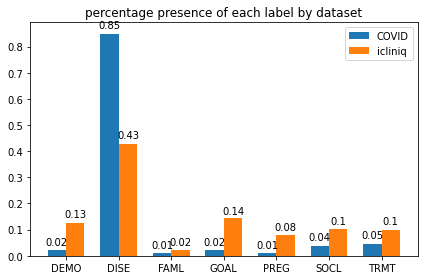

In [ ]:
utils.make_grouped_bar_chart(COVID_pred_labels, icliniq_pred_labels)

This heatmap displays a confusion matrix for the predicted and actual classes of the test dataset. Similar heatmaps can also be created for the COVID_annotated and icliniq_annotated datasets.

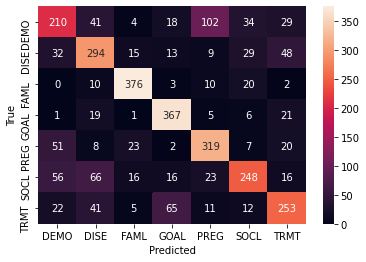

In [ ]:
utils.make_misclassification_heatmap(test_dataset.labels, test_pred_labels)